# Import all the library we need

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Input the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stock_df = pd.read_csv("/content/drive/MyDrive/Data Phython/UNVR.JK (3).csv")
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-22,9840.0,9900.0,9760.0,9760.0,8073.905762,8018000
1,2017-06-23,9760.0,9760.0,9760.0,9760.0,8073.905762,0
2,2017-06-26,9760.0,9760.0,9760.0,9760.0,8073.905762,0
3,2017-06-27,9760.0,9760.0,9760.0,9760.0,8073.905762,0
4,2017-06-28,9760.0,9760.0,9760.0,9760.0,8073.905762,0


In [ ]:

stock_df = stock_df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
stock_df.head()
stock_df.tail()

,date,open,high,low,close,adj_close,volume
1730,2024-06-13 00:00:00+00:00,3060.0,3120.0,3060.0,3060.0,3060.0,11469600
1731,2024-06-14 00:00:00+00:00,3090.0,3210.0,3070.0,3200.0,3200.0,31693600
1732,2024-06-19 00:00:00+00:00,3200.0,3200.0,3060.0,3070.0,3070.0,26712400
1733,2024-06-20 00:00:00+00:00,3090.0,3100.0,2950.0,3040.0,3040.0,15901600
1734,2024-06-21 00:00:00+00:00,3040.0,3100.0,2990.0,2990.0,2990.0,31954300


In [ ]:
print("Total number of days: ",stock_df.shape[0])
print("Total number of fields: ",stock_df.shape[1])

Total number of days:  1735
Total number of fields:  7


# Data Preprocessing

## Checking Null and NA value

In [ ]:
print("Null values:", stock_df.isnull().values.sum())

print("NA values:", stock_df.isna().values.any())

Null values: 0
NA values: False


No Null and NA values in the data

In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1735 non-null   object 
 1   open       1735 non-null   float64
 2   high       1735 non-null   float64
 3   low        1735 non-null   float64
 4   close      1735 non-null   float64
 5   adj_close  1735 non-null   float64
 6   volume     1735 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 95.0+ KB


## Convert Date field into datetime format

In [ ]:
stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True)

In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       1735 non-null   datetime64[ns, UTC]
 1   open       1735 non-null   float64            
 2   high       1735 non-null   float64            
 3   low        1735 non-null   float64            
 4   close      1735 non-null   float64            
 5   adj_close  1735 non-null   float64            
 6   volume     1735 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 95.0 KB


## Find the duration of dataset

In [ ]:
print("Starting date: ",stock_df.iloc[0][0])

print("Ending date: ", stock_df.iloc[-1][0])

print("Duration: ", stock_df.iloc[-1][0]-stock_df.iloc[0][0])

Starting date:  2017-06-22 00:00:00+00:00
Ending date:  2024-06-21 00:00:00+00:00
Duration:  2556 days 00:00:00


## Trend Comparison Between Stock Open Price, Close Price, High Price, Low Price

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(stock_df, x=stock_df.date, y=[stock_df['open'], stock_df['close'],
                                          stock_df['high'], stock_df['low']],
             labels={'date': 'Date','value':'Stock value'})

fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

## Export Only Close Price Data

This study uses closing price as the sole input feature for stock price forecasting. The closing price represents the final market consensus for a given trading day, integrating all available information such as intraday price movements, trading volume, and market sentiment.

Using a univariate time-series approach allows the models (LSTM, GRU, and XGBoost) to focus on learning temporal dependencies and sequential patterns without introducing noise from highly correlated or redundant features

In [ ]:
stock_df_close = stock_df[['date','close']]

print("Shape of close dataframe:", stock_df_close.shape)

Shape of close dataframe: (1735, 2)


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Taking only only last 1 year data for prediction </h3>
</div>



In [ ]:
stock_df_close_last_1_year = stock_df_close[stock_df_close['date'] > '2017-6-21']

stock_df_close_last_1_year_original_gt = stock_df_close_last_1_year.copy()

print("Total data for prediction: ",stock_df_close_last_1_year.shape[0])

Total data for prediction:  1735


### Plot the data

In [ ]:
fig = px.line(stock_df_close_last_1_year, x=stock_df_close_last_1_year.date, y=stock_df_close_last_1_year.close,labels={'date':'Date','close':'Close Stock'})

fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')

fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

## Data Splitting

The data is splitted into three: Training (80%), Validation (10%), and Testing (10%).

Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.

This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

After splitting the data into train, validation, and test sets, the optimal approach is to first normalize the train set, then apply the mean and standard deviation of the train set normalization to the validation and test set normalization.

In [ ]:
# Calculate sizes
training_size = int(len(stock_df_close_last_1_year) * 0.80)
val_size = int(len(stock_df_close_last_1_year) * 0.10)
test_size = len(stock_df_close_last_1_year) - training_size - val_size

# Convert sizes to integers
training_size = int(training_size)
val_size = int(val_size)
test_size = int(test_size)

# Split the data
train_data = stock_df_close_last_1_year.iloc[:training_size]
val_data = stock_df_close_last_1_year.iloc[training_size:training_size + val_size]
test_data = stock_df_close_last_1_year.iloc[training_size + val_size:]

# Print the shapes of the datasets
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)
print("validation_data: ", val_data.shape)

train_data:  (1388, 2)
test_data:  (174, 2)
validation_data:  (173, 2)


### Plot the close price after the splitting

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(train_data.index, train_data['close'], label='Train Data', color='blue')

# Plot validation data
plt.plot(val_data.index, val_data['close'], label='Validation Data', color='green')

# Plot test data
plt.plot(test_data.index, test_data['close'], label='Test Data', color='red')

# Add labels and title
plt.xlabel('days')
plt.ylabel('Close Price')
plt.title('Stock Close Price Over Time')
plt.legend()

# Show the plot
plt.show()

# Normalizing close price

**Key rule is fit() should NOT be used on test data, as test data should remain in its pristine form. The model should NOT learn it.**

We use **`fit_transform()`** on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data.

And then, we only use **`transform()`** on the test data because we use the scaling parameters learned on the train data to scale the test data.

We use **Min Max** to scale the data

In [ ]:
# Need to delete the 'date' column else will get below error
# `float() argument must be a string or a number, not 'Timestamp'``
del train_data['date']

del test_data['date']

del val_data['date']

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

val_data= scaler.transform(np.array(val_data).reshape(-1,1))

print(train_data.shape)

(1388, 1)


## Transforming the Close price to suite Time-series-analysis forecasting requirement

### Using lagged observations as features
Let’s start with using time steps as features. In other words, we’re trying to predict the next value, X(t+n), from the previous n observations Xt, X+1, …, and X(t+n-1). We use time step of 15 days

In [ ]:
# convert an array of values into a dataset matrix

def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15

X_train, y_train = create_sliding_window(train_data, time_step)

X_test, y_test = create_sliding_window(test_data, time_step)

X_val, y_val = create_sliding_window(val_data, time_step)


print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)
print("X_val: ", X_val.shape)
print("y_val", y_val.shape)

X_train:  (1372, 15)
y_train:  (1372,)
X_test:  (158, 15)
y_test (158,)
X_val:  (157, 15)
y_val (157,)


## For LSTM / GRU I need to reshape input to be a 3D Tensor of [samples, time steps, features]



    X = numpy.reshape(dataX, (len(dataX), seq_length, 1))

**Samples** - This is the len(dataX), or the amount of data points you have.

**Time steps** - A sample contains multiple time steps, and here time_steps means, the width of the sliding window (in this case its is 15).

**Features** - this is the number of features in every time step. In this case I have 1 feature (the closing price of the assets) per time step.

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
# Or in terms of TensorFlow / Keras => [batch_size, time steps, input_dim].

X_train =X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("X_val: ", X_val.shape)

X_train:  (1372, 15, 1)
X_test:  (158, 15, 1)
X_val:  (157, 15, 1)


# Model Building (GRU)

In [ ]:
model=Sequential()

model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))

model.add(GRU(32,return_sequences=True))

model.add(GRU(32))

model.add(Dropout(0.20))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_15 (GRU)                (None, 15, 32)            3360      
                                                                 
 gru_16 (GRU)                (None, 15, 32)            6336      
                                                                 
 gru_17 (GRU)                (None, 32)                6336      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16065 (62.75 KB)
Trainable params: 16065 (62.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the Data

Hyperparam:
- **epochs**: 200
- **Optimizer**: Adam
- **Loss function**: Mean squared error
- **Batch size**: 32

In [ ]:
history = model.fit(X_train,y_train, validation_data=(X_val,y_val),epochs=200, batch_size=32, verbose=1)

Epoch 1/200
43/43 [==============================] - 8s 42ms/step - loss: 0.0633 - val_loss: 0.0175
Epoch 2/200
43/43 [==============================] - 1s 18ms/step - loss: 0.0071 - val_loss: 4.4547e-04
Epoch 3/200
43/43 [==============================] - 1s 19ms/step - loss: 0.0054 - val_loss: 2.9897e-04
Epoch 4/200
43/43 [==============================] - 1s 19ms/step - loss: 0.0048 - val_loss: 2.8831e-04
Epoch 5/200
43/43 [==============================] - 1s 18ms/step - loss: 0.0047 - val_loss: 2.5127e-04
Epoch 6/200
43/43 [==============================] - 1s 18ms/step - loss: 0.0043 - val_loss: 2.0594e-04
Epoch 7/200
43/43 [==============================] - 1s 18ms/step - loss: 0.0041 - val_loss: 2.7880e-04
Epoch 8/200
43/43 [==============================] - 1s 23ms/step - loss: 0.0043 - val_loss: 1.9604e-04
Epoch 9/200
43/43 [==============================] - 1s 28ms/step - loss: 0.0037 - val_loss: 2.0772e-04
Epoch 10/200
43/43 [==============================] - 1s 29ms/step -

### Plotting loss chart

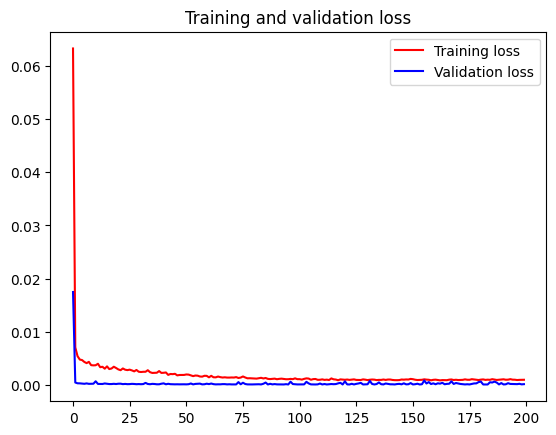

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.legend(loc=0)

plt.figure()


plt.show()

The loss values for training and validation have decreased dramatically since the first epoch, and there is no significant difference between the two. This indicates that the model is learning very well and there are no signs of overfitting.



# Model Evaluation

## Let's do the prediction

In [ ]:
val_predict=model.predict(X_val)

test_predict=model.predict(X_test)

val_predict.shape, test_predict.shape

5/5 [==============================] - 0s 5ms/step


((157, 1), (158, 1))

In [ ]:
train_predict=model.predict(X_train)

43/43 [==============================] - 0s 5ms/step


##  Transform back the data (denormalized)

In [ ]:
val_predict = scaler.inverse_transform(val_predict)

test_predict = scaler.inverse_transform(test_predict)

original_yval = scaler.inverse_transform(y_val.reshape(-1,1))

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

train_predict = scaler.inverse_transform(train_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))


## Evaluation metrices RMSE, MSE, MAE, and MAPE

Root Mean Square Error (RMSE), Mean Square Error (MSE), Mean absolute Error (MAE), and Mean absolute percentage error are a standard way to measure the error of a model in predicting quantitative data.

In [ ]:
print("Validation data RMSE: ", math.sqrt(mean_squared_error(original_yval, val_predict)))

print("Validation data MSE: ", mean_squared_error(original_yval,val_predict))

print("Validation data MAE: ", mean_absolute_error(original_yval,val_predict))

print("Validation data MAPE: ", mean_absolute_percentage_error(original_yval,val_predict))

print("-------------------------------------------------------------------------------------")

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))

print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

print("Test data MAPE: ", mean_absolute_percentage_error(original_ytest,test_predict))

Train data RMSE:  92.91927241997172
Train data MSE:  8633.991187056918
Train data MAE:  74.27272840366243
Train data MAPE:  0.01746311804324216
-------------------------------------------------------------------------------------
Test data RMSE:  89.5853459364791
Test data MSE:  8025.534206558632
Test data MAE:  69.41478256032437
Test data MAPE:  0.022156148409035695


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Explained variance regression score </h3>
</div>


explained_variance_score, EVS tells you how much variance is explained by your model. The maximum value is one. Higher the EVS better is your model.

The formula is written as follows: taken from [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score)

![](2022-10-04-22-38-55.png)

Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))

print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9962350198918951
Test data explained variance regression score: 0.9863443240912844


## R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best <br>
0 or < 0 = worse

---------

## Difference between r2_score and explained_variance_score?

The difference is that the explained variance use the biased variance to determine what fraction of the variance is explained. R-Squared uses the raw sums of squares. If the error of the predictor is unbiased, the two scores are the same.

The main difference is the **Mean of Error**; and if we look at the formulas

## $$R2 = 1 - [(Sum of Squared Residuals / n) / Variancey_actual]$$

## $$Explained Variance Score = 1 - [Variance(Ypredicted - Yactual) / Variancey_actual]$$

in which:

## Variance(Ypredicted - Yactual) = (Sum of Squared Residuals - Mean Error) / n


So, obviously the only difference is that we are subtracting the Mean Error from the first formula!

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.994794038250873
Test data R2 score: 0.9529616827799603


## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))

print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")

print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))

print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0005124949560008486
Test data MGD:  0.0018321388382315903
----------------------------------------------------------------------
Train data MPD:  3.3877449671734676
Test data MPD:  5.9374482381824825


## Comparison of original stock close price and predicted close price

**`np.empty_like()`** => Return a new array with the same shape and type as a given array.

In [ ]:
stock_df_close_last_1_year

,close
0,9760.0
1,9760.0
2,9760.0
3,9760.0
4,9760.0
...,...
1730,3060.0
1731,3200.0
1732,3070.0
1733,3040.0


## Plot the predicted stock

In [ ]:
# shift train predictions for plotting the look-ahead time for predicted stock values

# First delete the 'date' column from below df to make it a single column df
# so that train_predict_look_ahead variable can be properly structured
del stock_df_close_last_1_year['date']

look_back=time_step

# Shift train predictions for plotting the look-ahead time for predicted stock values
train_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)
train_predict_look_ahead[:, :] = np.nan
train_predict_look_ahead[look_back:len(train_predict) + look_back, :] = train_predict

print("Train predicted data: ", train_predict_look_ahead.shape)

# Shift validation predictions for plotting
val_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)
val_predict_look_ahead[:, :] = np.nan
val_predict_look_ahead[training_size + look_back:training_size + look_back + len(val_predict), :] = val_predict

print("Validation predicted data: ", val_predict_look_ahead.shape)

# Shift test predictions for plotting
test_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)
test_predict_look_ahead[:, :] = np.nan
test_predict_look_ahead[training_size + val_size + look_back:training_size + val_size + look_back + len(test_predict), :] = test_predict

print("Test predicted data: ", test_predict_look_ahead.shape)

# Create cycle names for plot legend
names = cycle(['Original close price', 'Train predicted close price', 'Validation predicted close price', 'Test predicted close price'])

# Create a DataFrame for plotting
plotdf = pd.DataFrame({
    'date': stock_df_close_last_1_year_original_gt['date'],
    'original_close': stock_df_close_last_1_year_original_gt['close'],
    'train_predicted_close': train_predict_look_ahead.reshape(-1).tolist(),
    'val_predicted_close': val_predict_look_ahead.reshape(-1).tolist(),
    'test_predicted_close': test_predict_look_ahead.reshape(-1).tolist()
})

# Plot using Plotly
fig = px.line(plotdf, x='date', y=['original_close', 'train_predicted_close', 'val_predicted_close', 'test_predicted_close'],
              labels={'value': 'Stock price', 'date': 'Date'})

fig.update_layout(title_text='Comparison between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

fig.for_each_trace(lambda t: t.update(name=next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1735, 1)
Validation predicted data:  (1735, 1)
Test predicted data:  (1735, 1)


# Predicting the Next Stock Price for 15 Days




In [ ]:
# for x_input, I need to pick the last 15 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1) # time_step is 15
print("x_input.shape ", x_input.shape)
print("x_input", x_input)

print('###########################################################################')

temp_input=list(x_input)
print(temp_input)

x_input.shape  (1, 15)
x_input [[-0.02151899 -0.02025316 -0.02531646 -0.01898734 -0.02658228 -0.02531646
  -0.03417722 -0.02658228 -0.0278481  -0.0278481  -0.0278481  -0.01012658
  -0.02658228 -0.03037975 -0.03670886]]
###########################################################################
[array([-0.02151899, -0.02025316, -0.02531646, -0.01898734, -0.02658228,
       -0.02531646, -0.03417722, -0.02658228, -0.0278481 , -0.0278481 ,
       -0.0278481 , -0.01012658, -0.02658228, -0.03037975, -0.03670886])]


In [ ]:
temp_input=temp_input[0].tolist()
len(temp_input)

15

In [ ]:
from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 15
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        y_pred = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,y_pred))
        temp_input.extend(y_pred[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(y_pred.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1)) # Reshape x_input to a 3D Tensor [samples, time steps, features] before feeding into the model
        y_pred = model.predict(x_input, verbose=0)
        temp_input.extend(y_pred[0].tolist())

        lst_output.extend(y_pred.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  15


In [ ]:
lst_output

[[-0.04333996772766113],
 [-0.049636125564575195],
 [-0.05579781532287598],
 [-0.061777353286743164],
 [-0.06756609678268433],
 [-0.07316583395004272],
 [-0.07857781648635864],
 [-0.08380335569381714],
 [-0.08884412050247192],
 [-0.09370172023773193],
 [-0.09837853908538818],
 [-0.10287725925445557],
 [-0.10720062255859375],
 [-0.11135208606719971],
 [-0.11533522605895996]]

## Plotting last 15 days of dataset and next predicted 15 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]


In [ ]:
temp_matrix = np.empty((len(last_days)+pred_days+1, 1))

temp_matrix[:] = np.nan

temp_matrix

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [ ]:
temp_matrix.shape

(31, 1)

### Need to convert to this (46, 1) matrix to (1, 46) Matrix

In [ ]:
temp_matrix = temp_matrix.reshape(1,-1).tolist()[0]


## Now for Predicting next 15 days based on previous 15 days of actual historical values - I need a single list in which the first 15 elements will be the 15 days of actual historical values and the next 15 days will be the predicted values

In [ ]:
last_original_days_value = temp_matrix

next_predicted_days_value = temp_matrix

last_original_days_value[0:time_step+1] = stock_df_close_last_1_year_original_gt[len(stock_df_close_last_1_year_original_gt)-time_step:]['close'].tolist()

next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

In [ ]:
last_original_days_value[0:time_step+1]

[3110.0,
 3120.0,
 3080.0,
 3130.0,
 3070.0,
 3080.0,
 3010.0,
 3070.0,
 3060.0,
 3060.0,
 3060.0,
 3200.0,
 3070.0,
 3040.0,
 2990.0,
 nan]

### The predicted stock price for 15 days

In [ ]:
next_predicted_days_value[time_step+1:]

[2937.614254951477,
 2887.874608039856,
 2839.19725894928,
 2791.958909034729,
 2746.227835416794,
 2701.9899117946625,
 2659.2352497577667,
 2617.9534900188446,
 2578.131448030472,
 2539.7564101219177,
 2502.8095412254333,
 2467.269651889801,
 2433.1150817871094,
 2400.3185200691228,
 2368.8517141342168]

In [ ]:
len(last_original_days_value[0:time_step+1])

16

In [ ]:
len(next_predicted_days_value[time_step+1:])

15

In [ ]:
new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

new_pred_plot.tail()


,last_original_days_value,next_predicted_days_value
26,2502.809541,2502.809541
27,2467.269652,2467.269652
28,2433.115082,2433.115082
29,2400.318520,2400.318520
30,2368.851714,2368.851714


In [ ]:
new_pred_plot.shape

(31, 2)

## Plot of the predicted stock

In [ ]:

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(visible=True, name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

# Plotting entire Closing Stock Price with next 15 days period of prediction

In [ ]:
# Convert stock_df_close_last_1_year to np.array
# Otherwise tolist() method can not be applied to them
stock_df_close_last_1_year = np.array(stock_df_close_last_1_year)

lstmdf=stock_df_close_last_1_year.tolist()

lstmdf.extend((np.array(new_pred_plot['next_predicted_days_value']).reshape(-1,1)).tolist())

lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()